In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
matplotlib.rcParams['font.family'] = "Arial"

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots

init_notebook_mode(connected=True)

import collections
import itertools

import scipy.stats as stats
from scipy.stats import norm
from scipy.special import boxcox1p

import statsmodels
import statsmodels.api as sm
#print(statsmodels.__version__)

from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet,  HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.utils import resample

from xgboost import XGBRegressor



import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [67]:
train_data = pd.read_csv('../data/train.csv')
train_data = train_data.drop(columns=['Unnamed: 0','City'])
dev_data = pd.read_csv('../data/dev.csv')
dev_data = dev_data.drop(columns=['Unnamed: 0','City'])
test_data = pd.read_csv('../data/test.csv')
test_data = test_data.drop(columns=['Unnamed: 0','City'])

In [55]:
train_data

,Price,Day,Room.Type,Shared.Room,Private.Room,Person.Capacity,Superhost,Multiple.Rooms,Business,Cleanliness.Rating,Guest.Satisfaction,Bedrooms,City.Center..km.,Metro.Distance..km.,Attraction.Index,Normalised.Attraction.Index,Restraunt.Index,Normalised.Restraunt.Index
0,344.245776,Weekday,Private room,False,True,4,False,0,0,8,85,1,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928
1,264.101422,Weekday,Private room,False,True,2,False,0,1,9,87,1,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700
2,485.552926,Weekday,Private room,False,True,2,True,0,0,10,98,1,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677
3,1001.804420,Weekday,Entire home/apt,False,False,4,False,0,0,9,96,2,3.719141,1.196112,106.226456,5.624761,133.876202,9.328686
4,909.474375,Weekday,Entire home/apt,False,False,2,False,0,0,10,96,1,1.009922,0.917115,409.858124,21.702260,555.114276,38.681161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29667,750.765491,Weekend,Entire home/apt,False,False,6,False,0,1,10,96,3,0.378804,0.203138,257.494817,18.440080,548.973296,13.268473
29668,715.938574,Weekend,Entire home/apt,False,False,6,False,0,1,10,100,3,0.530181,0.135447,219.402478,15.712158,438.756874,10.604584
29669,637.168969,Weekend,Entire home/apt,False,False,2,False,0,0,10,93,1,0.994051,0.202539,169.073402,12.107921,282.296424,6.822996
29670,301.054157,Weekend,Private room,False,True,2,False,0,0,10,87,1,3.044100,0.287435,109.236574,7.822803,158.563398,3.832416


In [57]:
train_data.columns

Index(['Price', 'Day', 'Room.Type', 'Shared.Room', 'Private.Room',
       'Person.Capacity', 'Superhost', 'Multiple.Rooms', 'Business',
       'Cleanliness.Rating', 'Guest.Satisfaction', 'Bedrooms',
       'City.Center..km.', 'Metro.Distance..km.', 'Attraction.Index',
       'Normalised.Attraction.Index', 'Restraunt.Index',
       'Normalised.Restraunt.Index'],
      dtype='object')

In [79]:
# train

# Encoding categorical features
categorical_features = train_data[['Day','Room.Type','Shared.Room','Private.Room','Superhost']]
categorical_features_one_hot = pd.get_dummies(categorical_features)
# Save transformed dataframe for future use¶
numerical_features =  train_data[['Price',
       'Person.Capacity', 'Multiple.Rooms', 'Business',
       'Cleanliness.Rating', 'Guest.Satisfaction', 'Bedrooms',
       'City.Center..km.', 'Metro.Distance..km.', 'Attraction.Index',
       'Normalised.Attraction.Index', 'Restraunt.Index',
       'Normalised.Restraunt.Index']]
y_train = np.log(numerical_features.Price)
numerical_features = numerical_features.drop(['Price'], axis=1)
X_train = np.concatenate((numerical_features, categorical_features_one_hot), axis=1)

# test

# Encoding categorical features
categorical_features = test_data[['Day','Room.Type','Shared.Room','Private.Room','Superhost']]
categorical_features_one_hot = pd.get_dummies(categorical_features)
# Save transformed dataframe for future use¶
numerical_features =  test_data[['Price',
       'Person.Capacity', 'Multiple.Rooms', 'Business',
       'Cleanliness.Rating', 'Guest.Satisfaction', 'Bedrooms',
       'City.Center..km.', 'Metro.Distance..km.', 'Attraction.Index',
       'Normalised.Attraction.Index', 'Restraunt.Index',
       'Normalised.Restraunt.Index']]
y_test = np.log(numerical_features.Price)
numerical_features = numerical_features.drop(['Price'], axis=1)
X_test = np.concatenate((numerical_features, categorical_features_one_hot), axis=1)


In [80]:
print('Dimensions of the training feature matrix: {}'.format(X_train.shape))
print('Dimensions of the training target vector: {}'.format(y_train.shape))
print('Dimensions of the test feature matrix: {}'.format(X_test.shape))
print('Dimensions of the test target vector: {}'.format(y_test.shape))

Dimensions of the training feature matrix: (29672, 20)
Dimensions of the training target vector: (29672,)
Dimensions of the test feature matrix: (6027, 20)
Dimensions of the test target vector: (6027,)


In [81]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [82]:
# Cross-validation
n_folds = 5

# squared_loss
def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
    return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

def rmse_lv_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
    return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

In [83]:
# Scoring basic models (no parameter tuning)

for Model in [LinearRegression, Ridge, Lasso, ElasticNet, RandomForestRegressor, XGBRegressor, HuberRegressor]:
    if Model == XGBRegressor: cv_res = rmse_cv(XGBRegressor(objective='reg:squarederror'))
    else: cv_res = rmse_cv(Model())
    print('{}: {:.5f} +/- {:5f}'.format(Model.__name__, -cv_res.mean(), cv_res.std()))

LinearRegression: 0.29390 +/- 0.163173
Ridge: 0.29373 +/- 0.163038
Lasso: 0.33125 +/- 0.110569
ElasticNet: 0.33125 +/- 0.110569
RandomForestRegressor: 0.33766 +/- 0.230768
XGBRegressor: 0.49310 +/- 0.440826
HuberRegressor: 0.30084 +/- 0.149088


### Random Forest Regressor

In [84]:
rfr_CV_baseline = -rmse_cv(RandomForestRegressor(random_state=42))
rfr_baseline = RandomForestRegressor(random_state=42)
rfr_baseline.fit(X_train, y_train) 
y_train_rfr = rfr_baseline.predict(X_train)
y_test_rfr = rfr_baseline.predict(X_test)
rfr_baseline_results = pd.DataFrame({'algorithm':['Random Forest Regressor [baseline]'],
            'CV error': rfr_CV_baseline.mean(), 
            'CV std': rfr_CV_baseline.std(),
            'training error': [mean_squared_error(y_train_rfr, y_train)],
            'test error': [mean_squared_error(y_test_rfr, y_test)]})

In [85]:
rf = RandomForestRegressor(random_state=42)
from pprint import pprint
print('Parameters currently in use: \n')
pprint(rf.get_params())

Parameters currently in use: 

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [86]:
#Number of trees in the forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop=2000,num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2,5,10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [87]:
rf_random = RandomizedSearchCV(estimator=rf, param_distributions = random_grid, n_iter=10, cv = 3, verbose=2, random_state=42, n_jobs=-1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   4.3s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   4.5s


/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   4.6s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  20.4s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  20.8s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  21.0s


/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=  34.8s


/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=  35.5s


/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=  35.2s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  14.7s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  14.2s


/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  14.5s


/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time= 1.6min


/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time= 1.6min
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   3.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   3.3s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time= 1.7min


/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   3.4s


/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 2.5min


/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 2.6min


/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 2.7min


/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time= 1.7min


/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time= 1.8min
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time= 1.7min
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time= 3.0min
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time= 4.9min
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time= 2.8min
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time= 5.0min
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time= 2.9min
[CV] END bootstrap=False, max_depth=5

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [88]:
rf_random.best_estimator_

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=200, random_state=42)

In [89]:
#best_random = rf_random.best_estimator_
best_random = RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=200, random_state=42)
rfr_CV_best = -rmse_cv(best_random)
best_random.fit(X_train, y_train) 
y_train_rfr = best_random.predict(X_train)
y_test_rfr = best_random.predict(X_test)
rfr_best_results = pd.DataFrame({'algorithm':['Random Forest Regressor'],
            'CV error': rfr_CV_best.mean(), 
            'CV std': rfr_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_rfr)],
            'test error': [mean_squared_error(y_test, y_test_rfr)],
            'training_r2_score': [r2_score(y_train, y_train_rfr)],
            'test_r2_score': [r2_score(y_test, y_test_rfr)]})
rfr_best_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,Random Forest Regressor,0.262665,0.143661,0.107201,0.130039,0.66868,0.620718


### XGBoost Regressor

In [90]:
# baseline
xgb_baseline = XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping=5)
kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
cv_res = cross_val_score(xgb_baseline, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
xgb_baseline.fit(X_train, y_train)
y_train_xgb_base = xgb_baseline.predict(X_train)
y_test_xgb_base = xgb_baseline.predict(X_test)
xgb_baseline_results = pd.DataFrame({'algorithm':['XGBRegressor[baseline]'],
            'CV error': cv_res.mean(), 
            'CV std': cv_res.std(),
            'training error': [mean_squared_error(y_train_xgb_base, y_train)]})

[16:23:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[16:23:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[16:23:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[16:23:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[16:24:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[16:24:26] WARNING: /Users/runner/work/xgboost/xgboost/python-pac

In [91]:
print(xgb_baseline)
xgb_baseline_results

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping=5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)


,algorithm,CV error,CV std,training error
0,XGBRegressor[baseline],-0.445657,0.380889,0.046132


#### Learning rate optimization

In [92]:
# Learning rate optimization
d = {'Learning Rate':[],
            'Mean CV Error': [],
            'CV Error Std': [],
            'Training Error': []}
for lr in [0.01, 0.05, 0.1, 0.5]:
    #continue
    xgb_model = XGBRegressor(n_estimators=1000, learning_rate=lr, early_stopping=5)
    cv_res = -cross_val_score(xgb_model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
    xgb_model.fit(X_train, y_train)
    y_train_xgb = xgb_model.predict(X_train)
    d['Learning Rate'].append(lr)
    d['Mean CV Error'].append(cv_res.mean())
    d['CV Error Std'].append(cv_res.std())
    # makes no sense to look at max/min when we only have 3 CV folds
    #d['Max CV Error'].append(max(cv_res)
    #d['Min CV Error'].append(max(cv_res)
    d['Training Error'].append(mean_squared_error(y_train_xgb, y_train))

[16:25:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[16:25:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[16:25:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[16:25:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[16:26:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[16:26:21] WARNING: /Users/runner/work/xgboost/xgboost/python-pac

In [93]:
d

{'Learning Rate': [0.01, 0.05, 0.1, 0.5],
 'Mean CV Error': [0.39585250432188335,
  0.44565714123972366,
  0.519028002139432,
  0.4857614282814874],
 'CV Error Std': [0.3234359238336714,
  0.38088928173823694,
  0.5007243794369618,
  0.4006260957882327],
 'Training Error': [0.08877970163921717,
  0.046131923547263046,
  0.02825152057534665,
  0.0020229255157588927]}

In [94]:
# to run the search, comment out 'continue' in the for loop
# here are the results I got
d = {'Learning Rate': [0.01, 0.05, 0.1, 0.5],
 'Mean CV Error': [0.39585250432188335,
  0.44565714123972366,
  0.519028002139432,
  0.4857614282814874],
 'CV Error Std': [0.3234359238336714,
  0.38088928173823694,
  0.5007243794369618,
  0.4006260957882327],
 'Training Error': [0.08877970163921717,
  0.046131923547263046,
  0.02825152057534665,
  0.0020229255157588927]}

xgb_tuning_1 = pd.DataFrame(d)
xgb_tuning_1

,Learning Rate,Mean CV Error,CV Error Std,Training Error
0,0.01,0.395853,0.323436,0.088780
1,0.05,0.445657,0.380889,0.046132
2,0.10,0.519028,0.500724,0.028252
3,0.50,0.485761,0.400626,0.002023


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Mean Squared Error')

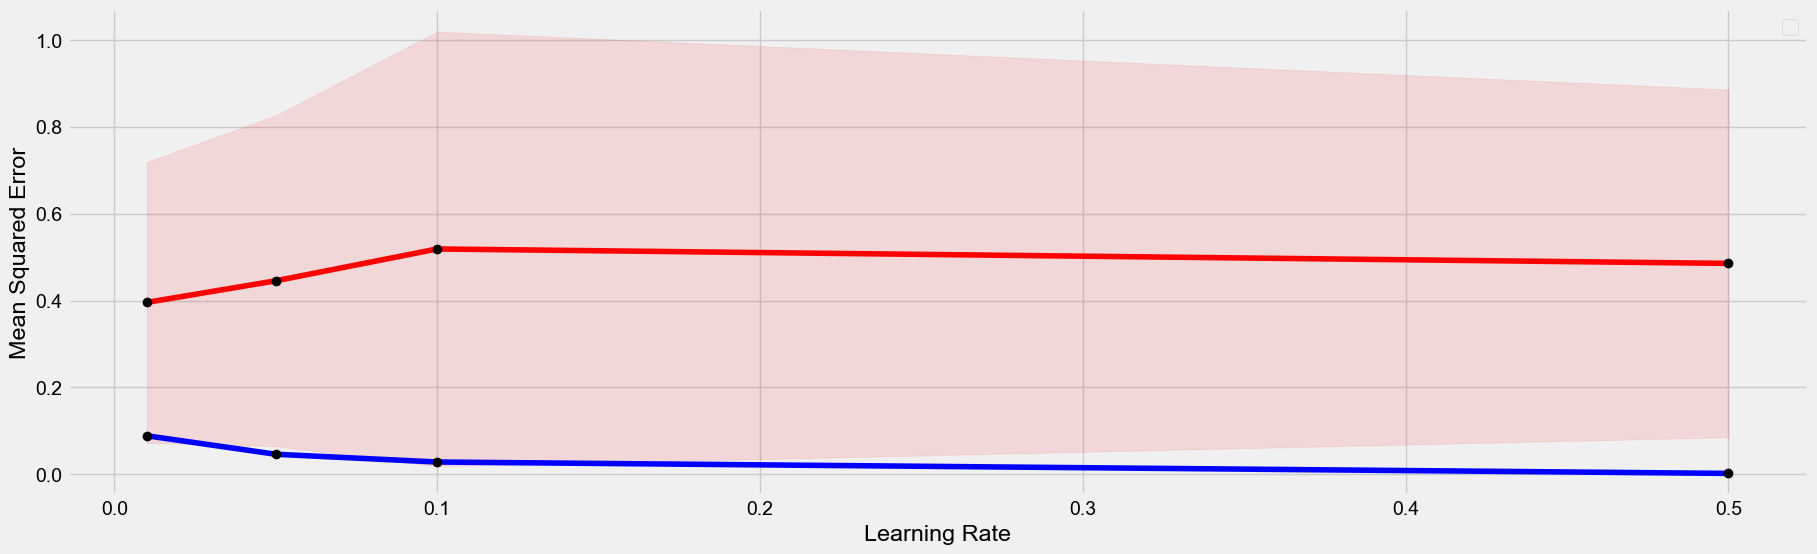

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(20,6))

ax.plot(xgb_tuning_1['Learning Rate'], xgb_tuning_1['Mean CV Error'], color='red')
ax.plot(xgb_tuning_1['Learning Rate'], xgb_tuning_1['Mean CV Error'], 'o', color='black')
ax.fill_between(xgb_tuning_1['Learning Rate'], xgb_tuning_1['Mean CV Error'] - xgb_tuning_1['CV Error Std'], xgb_tuning_1['Mean CV Error'] + xgb_tuning_1['CV Error Std'], color='r', alpha=.1)
ax.plot(xgb_tuning_1['Learning Rate'], xgb_tuning_1['Training Error'], color='blue')
ax.plot(xgb_tuning_1['Learning Rate'], xgb_tuning_1['Training Error'], 'o', color='black')
ax.legend()

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Mean Squared Error')
#ax.set_title('')

#### max_depth and min_child_weight optimization

In [95]:
d = {'max_depth':[],
             'min_child_weight': [],
            'Mean CV Error': [],
            'CV Error Std': [],
            'Training Error': []}
xgbreg = XGBRegressor(n_estimators=2, learning_rate=0.05, early_stopping=5)
params2 = {'max_depth': list(range(3,10,2)), 'min_child_weight': list(range(1,6,2))}
#print(params2)
#xgb_random.fit(X_train, y_train)
kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(X_train)
for md in params2['max_depth']:
    for mcw in params2['min_child_weight']:
        #continue
        xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.1, early_stopping=5, max_depth=md, min_child_weight=mcw )
        cv_res = -cross_val_score(xgb_model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
        xgb_model.fit(X_train, y_train)
        y_train_xgb = xgb_model.predict(X_train)
        d['max_depth'].append(md)
        d['min_child_weight'].append(mcw)
        d['Mean CV Error'].append(cv_res.mean())
        d['CV Error Std'].append(cv_res.std())
        # makes no sense to look at max/min when we only have 3 CV folds
        #d['Max CV Error'].append(max(cv_res)
        #d['Min CV Error'].append(max(cv_res)
        d['Training Error'].append(mean_squared_error(y_train_xgb, y_train))

#print(d)

[16:45:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[16:45:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[16:45:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[16:46:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[16:46:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[16:46:16] WARNING: /Users/runner/work/xgboost/xgboost/python-pac

In [96]:
d

{'max_depth': [3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
 'min_child_weight': [1, 3, 5, 1, 3, 5, 1, 3, 5, 1, 3, 5],
 'Mean CV Error': [0.7624662475392725,
  0.5171436248355028,
  0.5078563104590382,
  0.6913261921139727,
  0.48104389833274563,
  0.4968057757132587,
  0.5030541732101754,
  0.40572286352244535,
  0.41407143550743897,
  0.4143173742903625,
  0.38255673482267805,
  0.3945065900155192],
 'CV Error Std': [0.952993788279011,
  0.5016517695136861,
  0.46846763891410015,
  0.8011303802352099,
  0.430525614014101,
  0.45495805447996185,
  0.48115617748389133,
  0.3294831229715725,
  0.34120075860683236,
  0.3510615094007149,
  0.3012642380200232,
  0.321791670601465],
 'Training Error': [0.08905710327974693,
  0.08951420622593678,
  0.090805000181737,
  0.04382600228741113,
  0.04320507057280096,
  0.04612290220157045,
  0.015651019030351238,
  0.016007241016428957,
  0.018429311054760786,
  0.0037253224018287297,
  0.005055610097554713,
  0.005964209689202214]}

In [97]:

# to run the search, comment out 'continue' in the for loop
# here are the results I got

d = {'max_depth': [3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
 'min_child_weight': [1, 3, 5, 1, 3, 5, 1, 3, 5, 1, 3, 5],
 'Mean CV Error': [0.7624662475392725,
  0.5171436248355028,
  0.5078563104590382,
  0.6913261921139727,
  0.48104389833274563,
  0.4968057757132587,
  0.5030541732101754,
  0.40572286352244535,
  0.41407143550743897,
  0.4143173742903625,
  0.38255673482267805,
  0.3945065900155192],
 'CV Error Std': [0.952993788279011,
  0.5016517695136861,
  0.46846763891410015,
  0.8011303802352099,
  0.430525614014101,
  0.45495805447996185,
  0.48115617748389133,
  0.3294831229715725,
  0.34120075860683236,
  0.3510615094007149,
  0.3012642380200232,
  0.321791670601465],
 'Training Error': [0.08905710327974693,
  0.08951420622593678,
  0.090805000181737,
  0.04382600228741113,
  0.04320507057280096,
  0.04612290220157045,
  0.015651019030351238,
  0.016007241016428957,
  0.018429311054760786,
  0.0037253224018287297,
  0.005055610097554713,
  0.005964209689202214]} 
xgb_tuning_2 = pd.DataFrame(d)
xgb_tuning_2

,max_depth,min_child_weight,Mean CV Error,CV Error Std,Training Error
0,3,1,0.762466,0.952994,0.089057
1,3,3,0.517144,0.501652,0.089514
2,3,5,0.507856,0.468468,0.090805
3,5,1,0.691326,0.801130,0.043826
4,5,3,0.481044,0.430526,0.043205
5,5,5,0.496806,0.454958,0.046123
6,7,1,0.503054,0.481156,0.015651
7,7,3,0.405723,0.329483,0.016007
8,7,5,0.414071,0.341201,0.018429
9,9,1,0.414317,0.351062,0.003725


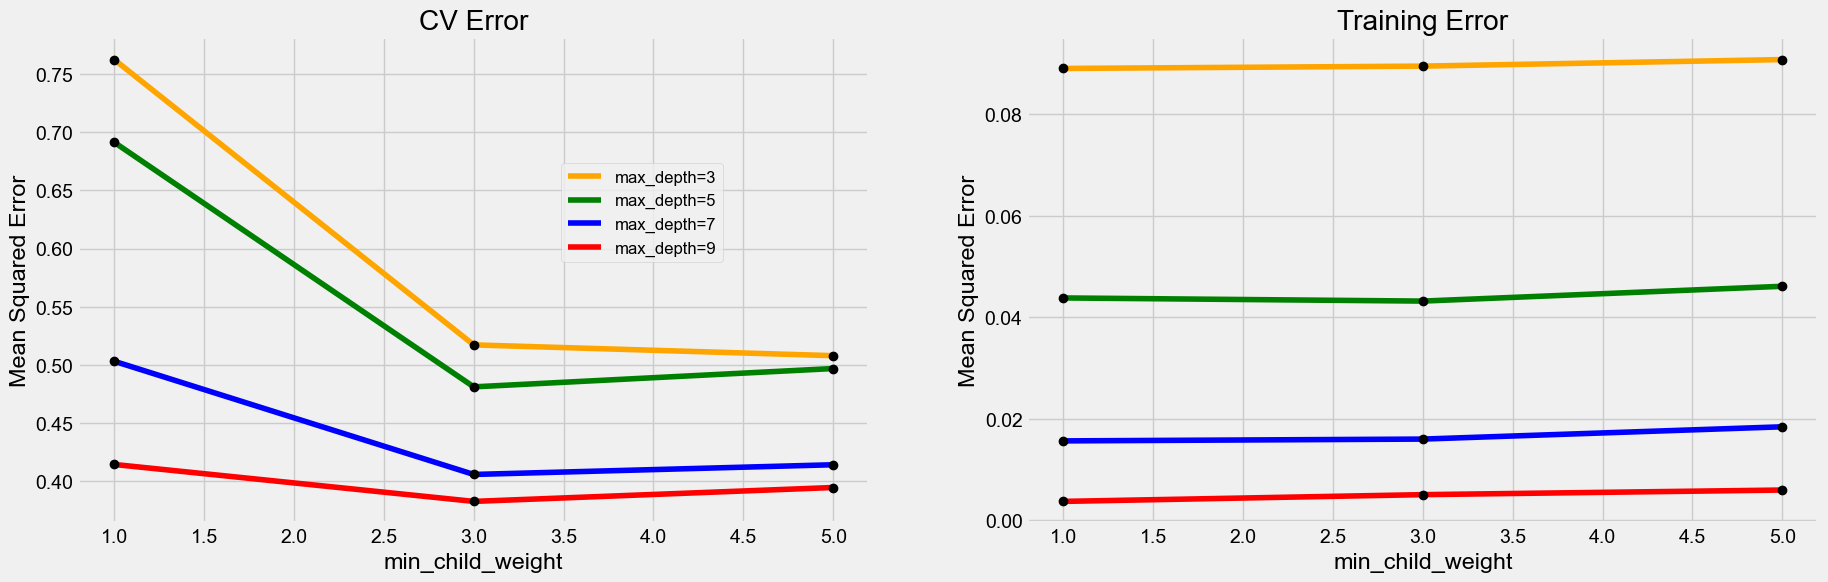

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(20,6))

colors = ['orange','green','blue','red']

for i, md in enumerate(params2['max_depth']):
    color = colors[i]
    xgb_tuning_3 = xgb_tuning_2[xgb_tuning_2['max_depth']==md]
    axes[0].plot(xgb_tuning_3['min_child_weight'], xgb_tuning_3['Mean CV Error'], color=color, label= 'max_depth='+str(md))
    axes[0].plot(xgb_tuning_3['min_child_weight'], xgb_tuning_3['Mean CV Error'], 'o', color='black', label='_nolegend_')
    #ax.fill_between(xgb_tuning_3['Max_depth'], xgb_tuning_3['Mean CV Error'] - xgb_tuning_3['CV Error Std'], 
                    #xgb_tuning_3['Mean CV Error'] + xgb_tuning_3['CV Error Std'], color='r', alpha=.1, label='_nolegend_')
    axes[1].plot(xgb_tuning_3['min_child_weight'], xgb_tuning_3['Training Error'], color=color, label='max_depth='+str(md))
    axes[1].plot(xgb_tuning_3['min_child_weight'], xgb_tuning_3['Training Error'], 'o', color='black', label='_nolegend_')

for ax in axes:
    ax.set_xlabel('min_child_weight')
    ax.set_ylabel('Mean Squared Error')
    
axes[0].set_title('CV Error')
axes[1].set_title('Training Error')

axes[0].legend(fontsize=12, bbox_to_anchor=(0.6, .52, .7, .602), loc=3,)

In [100]:
print('Optimal parameter values are: ')
best = xgb_tuning_2.iloc[xgb_tuning_2.idxmin()['Mean CV Error']]
print('max_depth: {}'.format(int(best['max_depth'])))
print('min_child_weight: {}'.format(int(best['min_child_weight'])))

Optimal parameter values are: 
max_depth: 9
min_child_weight: 3


In [106]:
# best 
xbgreg_best = XGBRegressor(n_estimators=1000, learning_rate=0.1, early_stopping=5, max_depth=9, min_child_weight=3 )
xbgreg_CV_best = -rmse_cv(xbgreg_best)
xbgreg_best.fit(X_train, y_train) 
y_train_xgbreg = xbgreg_best.predict(X_train)
y_test_xgbreg = xbgreg_best.predict(X_test)
xgb_best_results = pd.DataFrame({'algorithm':['XGBRegressor'],
            'CV error': xbgreg_CV_best.mean(), 
            'CV std': xbgreg_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_xgbreg)],
            'test error': [mean_squared_error(y_test, y_test_xgbreg)],
            'training_r2_score': [r2_score(y_train, y_train_xgbreg)],
            'test_r2_score': [r2_score(y_test, y_test_xgbreg)]})
xgb_best_results

[17:36:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[17:36:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[17:37:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[17:37:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[17:38:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[17:38:50] WARNING: /Users/runner/work/xgboost/xgboost/python-pac

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,XGBRegressor,0.382557,0.301264,0.005056,0.08504,0.984375,0.751965
